In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy.signal import medfilt2d

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math

In [29]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

m_data_file_list = ['/data6/HERA/HERA_imaging/redundancy_analysis/zen.2458042.12552.xx.HH.uv.m1','/data6/HERA/HERA_imaging/redundancy_analysis/zen.2458042.12552.yy.HH.uv.m1','/data6/HERA/HERA_imaging/redundancy_analysis/zen.2458042.12552.yx.HH.uv.m1','/data6/HERA/HERA_imaging/redundancy_analysis/zen.2458042.12552.xy.HH.uv.m1']

uv = UVData()


In [ ]:

uv.read_miriad(data_file_list)


In [30]:

for file_name, output_file_name in zip(data_file_list,m_data_file_list):
    
    uv.read_miriad(file_name)

    ant1 = 1
    ant2 = 11

    ind1 = np.where(ant1 == uv.ant_1_array)[0]

    ind2 = np.where(ant2 == uv.ant_1_array)[0]

    uv.ant_1_array[ind1] = ant2

    uv.ant_1_array[ind2] = ant1

    ind1 = np.where(ant1 == uv.ant_2_array)[0]

    ind2 = np.where(ant2 == uv.ant_2_array)[0]

    uv.ant_2_array[ind1] = ant2

    uv.ant_2_array[ind2] = ant1
    
    uv.write_miriad(output_file_name,clobber=True)


File exists: clobbering
File exists: clobbering
File exists: clobbering
File exists: clobbering


In [31]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [32]:

am = ant_metrics.Antenna_Metrics(m_data_file_list, reds, fileformat = 'miriad')


In [ ]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))
    
print bases


In [ ]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)
        
    
print nonreds


In [23]:
v = deepcopy (uv)


In [ ]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(v.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(v.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(v.antenna_positions[ant_1_ind]-v.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(v.freq_array[0][-1]-v.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = v.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(v.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.zeros((60,1024,4),dtype = complex)
    
    result[:,:,0] = np.fft.fftn(temp[:,:,0])
    
    result[:,:,1] = np.fft.fftn(temp[:,:,1])
    
    result[:,:,2] = np.fft.fftn(temp[:,:,2])
    
    result[:,:,3] = np.fft.fftn(temp[:,:,3])
    
    return result
    

In [ ]:

def noise(amp,width):
    
    real = np.random.normal(amp,width,(60,1024,4))
    
    imag = np.random.normal(amp,width,(60,1024,4))
    
    sig = np.array(real,dtype = complex)
    
    sig.imag = imag
    
    result = sig
    
    return result


In [ ]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(v.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(v.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
    

In [ ]:

new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

sig_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

noi_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)

s_width = 1

s_amp = 0

i_width = 0.3

i_amp = 0

n_width = 0.5

n_amp = 0

xant = 23

x_width = 0.

x_amp = 0

for i in reds:
        
    sig = signal(s_amp,s_width,i[0])
    
    print 'working'
        
    for j in i:
        
        x_sig = 0
        
        i_sig = signal(i_amp,i_width,j)
        
        if ((j[0] == xant) or (j[1] == xant)):
            
            x_sig = signal(x_amp,x_width,j)
            
            norm_power = float(s_width**2)
            
            new_power = float(norm_power + i_width**2 + x_width**2)
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig + x_sig) * ratio
            
        else:
            
            norm_power = float(s_width**2)
            
            new_power = float(norm_power + i_width**2)
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig) * ratio
            
        indices = v.antpair2ind(j[0],j[1])
            
        noi = noise(n_amp,n_width)
        
        visibility = sigs + noi
            
        new_data_array[indices,0,:,:] = visibility
        
        sig_data_array[indices,0,:,:] = sig
        
        noi_data_array[indices,0,:,:] = noi
            

In [ ]:

for i in nonreds:
    
    print 'working'
    
    sig = signal(s_amp,s_width,i)
    
    i_sig = signal(i_amp,i_width,i)
    
    indices = v.antpair2ind(i[0],i[1])
            
    noi = noise(n_amp,n_width)
    
    x_sig = 0
    
    if ((i[0] == xant) or (i[1] == xant)):
            
        x_sig = signal(x_amp,x_width,i)
            
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2 + x_width**2)
            
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig + x_sig) * ratio
        
    else:
        
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2)
            
        ratio = np.sqrt(norm_power/new_power)        
        
        sigs = (sig + i_sig) * ratio
            
    visibility = sigs + noi
            
    new_data_array[indices,0,:,:] = visibility
    
    sig_data_array[indices,0,:,:] = sig
        
    noi_data_array[indices,0,:,:] = noi
    

In [ ]:

print new_data_array


In [ ]:
v.data_array = new_data_array

In [ ]:

data = v.get_data(23,71,'xx')

plt.figure(figsize=(6,6))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()



data = v.get_data(36,87,'xx')

plt.figure(figsize=(6,6))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()

In [ ]:

data = v.get_data(37,88,'xx')

plt.figure(figsize=(10,10))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


In [ ]:

data = v.get_data(0,1,'xx')

plt.figure(figsize=(10,10))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


In [ ]:
am.data.data_array = new_data_array

In [33]:
am.xants = []

In [34]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [35]:
z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)

In [36]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


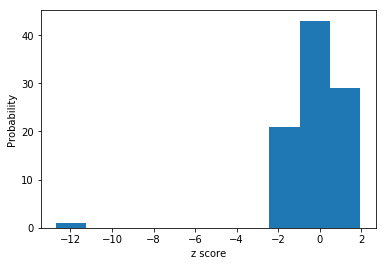

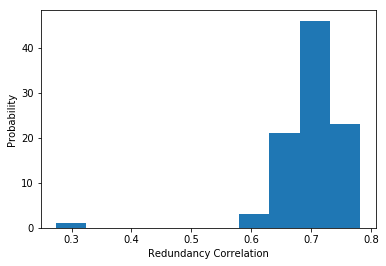

In [37]:
plt.figure()
plt.hist(values)
plt.xlabel('z score')
plt.ylabel('Probability')
#plt.xlim(-2,2)
plt.show()

plt.figure()
plt.hist(values_raw)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

In [39]:

am.iterative_antenna_metrics_and_flagging(crossCut = 5,deadCut = 5)

print am.xants


[(50, 'x'), (11, 'x'), (1, 'x'), (1, 'y'), (11, 'y')]


In [40]:

def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    
    if ants is None:
        
        ants = list(set([key[0] for key in metrics.keys()]))
        
    if antpols is None:
        
        antpols = list(set([key[1] for key in metrics.keys()]))
        
    for antpol in antpols:
        
        for i,ant in enumerate(ants):
            
            metric = 0
            
            if metrics.has_key((ant,antpol)):
                
                metric = metrics[(ant,antpol)]
                
            plt.plot(i,metric,'.')
            
            plt.annotate(str(ant) + antpol, xy = (i,metrics[(ant,antpol)]))
            
        plt.gca().set_prop_cycle(None)
        
    plt.title(title)
    
    plt.xlabel(xlabel)
    
    plt.ylabel(ylabel)
    
    plt.show()
        

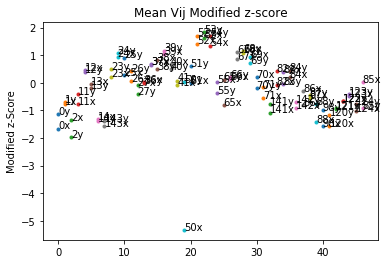

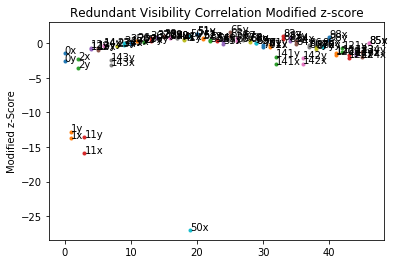

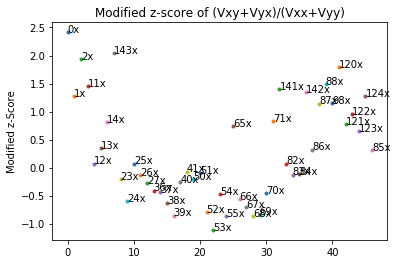

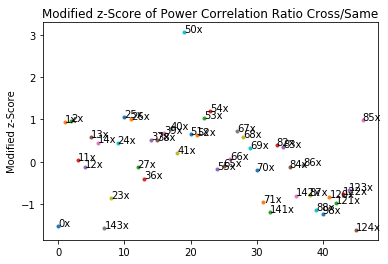

In [41]:

plt.figure()

plot_metric(am.finalModzScores['meanVij'],title='Mean Vij Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['redCorr'],title = 'Redundant Visibility Correlation Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['meanVijXPol'],antpols = ['x'], title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()

plot_metric(am.finalModzScores['redCorrXPol'], antpols = ['x'], title = 'Modified z-Score of Power Correlation Ratio Cross/Same')


In [42]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [43]:
z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)

In [44]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


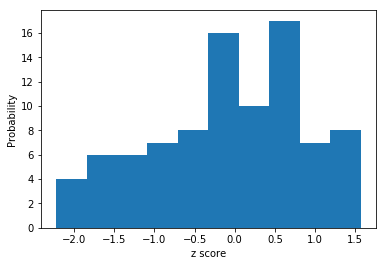

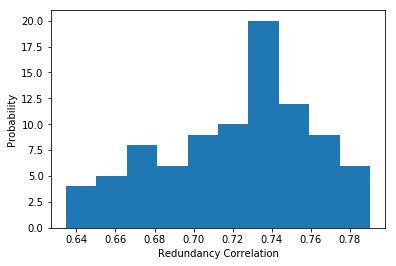

In [45]:
plt.figure()
plt.hist(values)
plt.xlabel('z score')
plt.ylabel('Probability')
#plt.xlim(-2,2)
plt.show()

plt.figure()
plt.hist(values_raw)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

In [46]:
print np.mean(values)
print np.mean(values_raw)

-0.0557495743519
0.72194810206
